In [19]:
import numpy as np
import pickle as pkl
import torch
import umap
import pandas as pd
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import style
import palettable
from palettable.tableau import Tableau_20 as pallette
sns.set() # Setting seaborn as default style even if use only matplotlib
sns.set_palette(pallette.mpl_colors)

# sns.set_palette(ListedColormap(palette.mpl_colormap))
# style.use('seaborn')


In [20]:
config = {
            "bias": [[-0.5, 0.5],
                     [0.5, -0.5],
                     [-0.5, 0.5],
                     [-0.5, 0.5],
                     [0, 0],
                     [0, 0]],
            "base_angular_freq": [[1*np.pi, 2*np.pi],
                                  [1*np.pi, 2*np.pi],
                                  [1*np.pi, 1*np.pi],
                                  [1*np.pi, 1*np.pi],
                                  [3*np.pi, 2*np.pi],
                                  [3*np.pi, 2*np.pi]],
            "base_amplitude": [[0.5, 0.5],
                               [0.5, 0.5],
                               [0.0, 0.5],
                               [0.0, 0.5],
                               [0.5, 0.5],
                               [0.5, 0.5]],
            "transient_bool": [False, False, False, True, False, False],
            "transient_start": [[np.NaN, np.NaN],
                                [np.NaN, np.NaN],
                                [np.NaN, np.NaN],
                                [125, 250],
                                [np.NaN, np.NaN],
                                [np.NaN, np.NaN]],
            "transient_amplitude": [[np.NaN, np.NaN],
                                    [np.NaN, np.NaN],
                                    [np.NaN, np.NaN],
                                    [-0.15, 0.15],
                                    [np.NaN, np.NaN],
                                    [np.NaN, np.NaN]],
            "singularity_bool": [False, False, False, False, False, True],
            "singularity_start": [[np.NaN, np.NaN],
                                  [np.NaN, np.NaN],
                                  [np.NaN, np.NaN],
                                  [np.NaN, np.NaN],
                                  [np.NaN, np.NaN],
                                  [50, 300]],
            "singularity_amplitude": [[np.NaN, np.NaN],
                                      [np.NaN, np.NaN],
                                      [np.NaN, np.NaN],
                                      [np.NaN, np.NaN],
                                      [np.NaN, np.NaN],
                                      [-0.3, 0.3]],
        }

classes = len(config["bias"])
channels = len(config["bias"][0])
length = 512
t = np.arange(length)
singularity_width = 16 # int(np.floor(np.log2(length)))
transient_width = 64 # int(np.floor(np.log2(length)))


print(f"{classes} classes, with {channels} channels")

6 classes, with 2 channels


# Make pandas dataframe

In [21]:
data = []

for cls in range(classes):
    
    for chn in range(channels):
        
        signals = np.zeros((length, 3))

        # Add low-resolution signal bias
        for res in range(3):
            signals[:, res] += config["bias"][cls][chn]

        # Add low-resolution base signal
        mid_res = config["base_amplitude"][cls][chn] * np.cos((config["base_angular_freq"][cls][chn] * t / length) - 0)
        for res in range(3):
            signals[:, res] += mid_res
            
        # Add mid-resolution
        s_t1 = config["transient_start"][cls][chn]
        for res in range(1,3):
            if s_t1 is not np.NaN:
                signals[s_t1:s_t1+transient_width, res] += config["transient_amplitude"][cls][chn]

        # Add high-resolution
        s_t1 = config["singularity_start"][cls][chn]
        if s_t1 is not np.NaN:
            signals[s_t1:s_t1+singularity_width, 2] += config["singularity_amplitude"][cls][chn]
  
        for i in range(length):
            for res_idx, res in enumerate(["Low-resolution", "Mid-resolution", "High-resolution"]):
                data.append([i + length*chn, res, cls + 1, signals[i, res_idx]])
                
        
                
    
df = pd.DataFrame(data, columns=["loci", "resolution", "class", "signal"])
print(df)


       loci       resolution  class    signal
0         0   Low-resolution      1  0.000000
1         0   Mid-resolution      1  0.000000
2         0  High-resolution      1  0.000000
3         1   Low-resolution      1 -0.000009
4         1   Mid-resolution      1 -0.000009
...     ...              ...    ...       ...
18427  1022   Mid-resolution      6  0.499849
18428  1022  High-resolution      6  0.499849
18429  1023   Low-resolution      6  0.499962
18430  1023   Mid-resolution      6  0.499962
18431  1023  High-resolution      6  0.499962

[18432 rows x 4 columns]


# Plot with seaborn

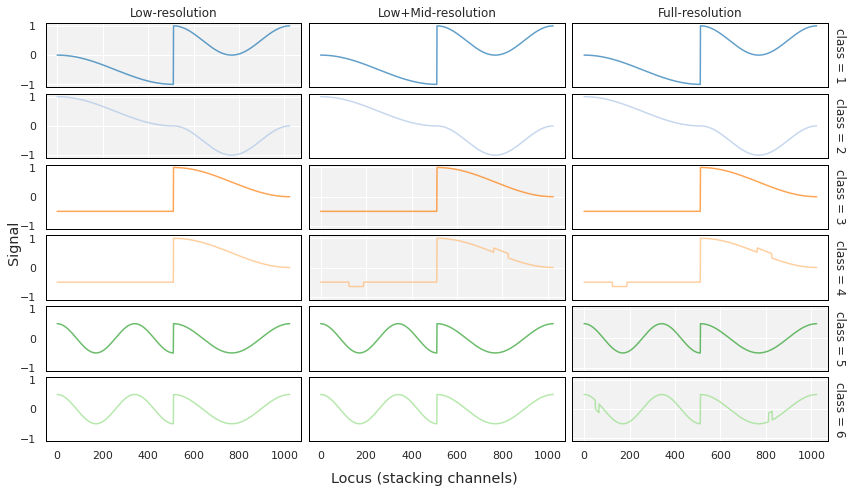

In [22]:
g = sns.FacetGrid(df, col="resolution", row="class", hue="class", margin_titles=True, despine=False, height=1.15, aspect=3.5)
g.map(sns.lineplot, "loci", "signal", alpha=.7)
g.figure.subplots_adjust(wspace=0.03, hspace=0.1)
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)

axes = g.axes.flatten()
for res_idx, res in enumerate(["Low-resolution", "Low+Mid-resolution", "Full-resolution"]):
    axes[res_idx].set_title(res)

g.set_xlabels(label="", clear_inner=True, )
g.set_ylabels(label="", clear_inner=True, )
g.fig.supxlabel("Locus (stacking channels)")
g.fig.supylabel("Signal")


for ax in g.axes.flatten(): # Loop directly on the flattened axes 
    for _, spine in ax.spines.items():
        spine.set_visible(True) # You have to first turn them on
        spine.set_color('black')
        spine.set_linewidth(1)
        
for (row_val, col_val), ax in g.axes_dict.items():
    if (row_val == 1 or row_val == 2) and col_val == "Low-resolution":
        ax.set_facecolor(".95")
    elif (row_val == 3 or row_val == 4) and col_val == "Mid-resolution":
        ax.set_facecolor(".95")
    elif (row_val == 5 or row_val == 6) and col_val == "High-resolution":
        ax.set_facecolor(".95")
    else:
        ax.set_facecolor((0, 0, 0, 0))
        
plt.savefig("toy1.pdf", dpi=500, format='pdf', transparent=True)

# Analyse Wave-LSTM model output

In [23]:
with open("../output.pkl", 'rb') as file:
    meta_results = pkl.load(file)

J = len(meta_results["hidden"])
lbls = meta_results["labels"].cpu().numpy()

print(meta_results["labels"].shape)
print(J)
print(list(meta_results.keys()))

torch.Size([64])
11
['filter_bank', 'pred_recurrent_recon', 'true_recurrent_recon', 'hidden', 'labels']


In [24]:
data = []
for j_res, j_name in zip([i for i in range(J)], [f"{j}-resolution" for j in range(J)]): 

    h_j = meta_results["hidden"][j_res].cpu().numpy()
    coef_j = meta_results["filter_bank"][j_res].cpu().numpy()

    # UMAP of scale embeddings
    reducer = umap.UMAP()
    scaled_h_j = StandardScaler().fit_transform(h_j)
    embedding = reducer.fit_transform(scaled_h_j)
    
    # UMAP of true wavelet coefficents
    reducer_true = umap.UMAP()
    scaled_coef = StandardScaler().fit_transform(coef_j)
    embedding_true = reducer_true.fit_transform(scaled_coef)
   
    for i in range(embedding.shape[0]):
        data.append([embedding[i, 0], embedding[i, 1], 
                     embedding_true[i, 0], embedding_true[i, 1], 
                     j_name, lbls[i] + 1])

df_emb = pd.DataFrame(data, columns=["UMAP-1", "UMAP-2", "coef-UMAP-1", "coef-UMAP-2", "resolution", "class"])
print(df_emb.head())

      UMAP-1     UMAP-2  coef-UMAP-1  coef-UMAP-2    resolution  class
0  14.243215  10.204543    -2.042111    15.682354  0-resolution      6
1  -5.199455  17.889832     0.116446     0.697419  0-resolution      2
2  -6.880182 -17.319073     1.320702    -1.199399  0-resolution      1
3  14.314451   9.205354    -3.122171    17.859959  0-resolution      6
4  -5.219117  18.054359     1.357331    -0.566406  0-resolution      2


## UMAP of the scale embeddings

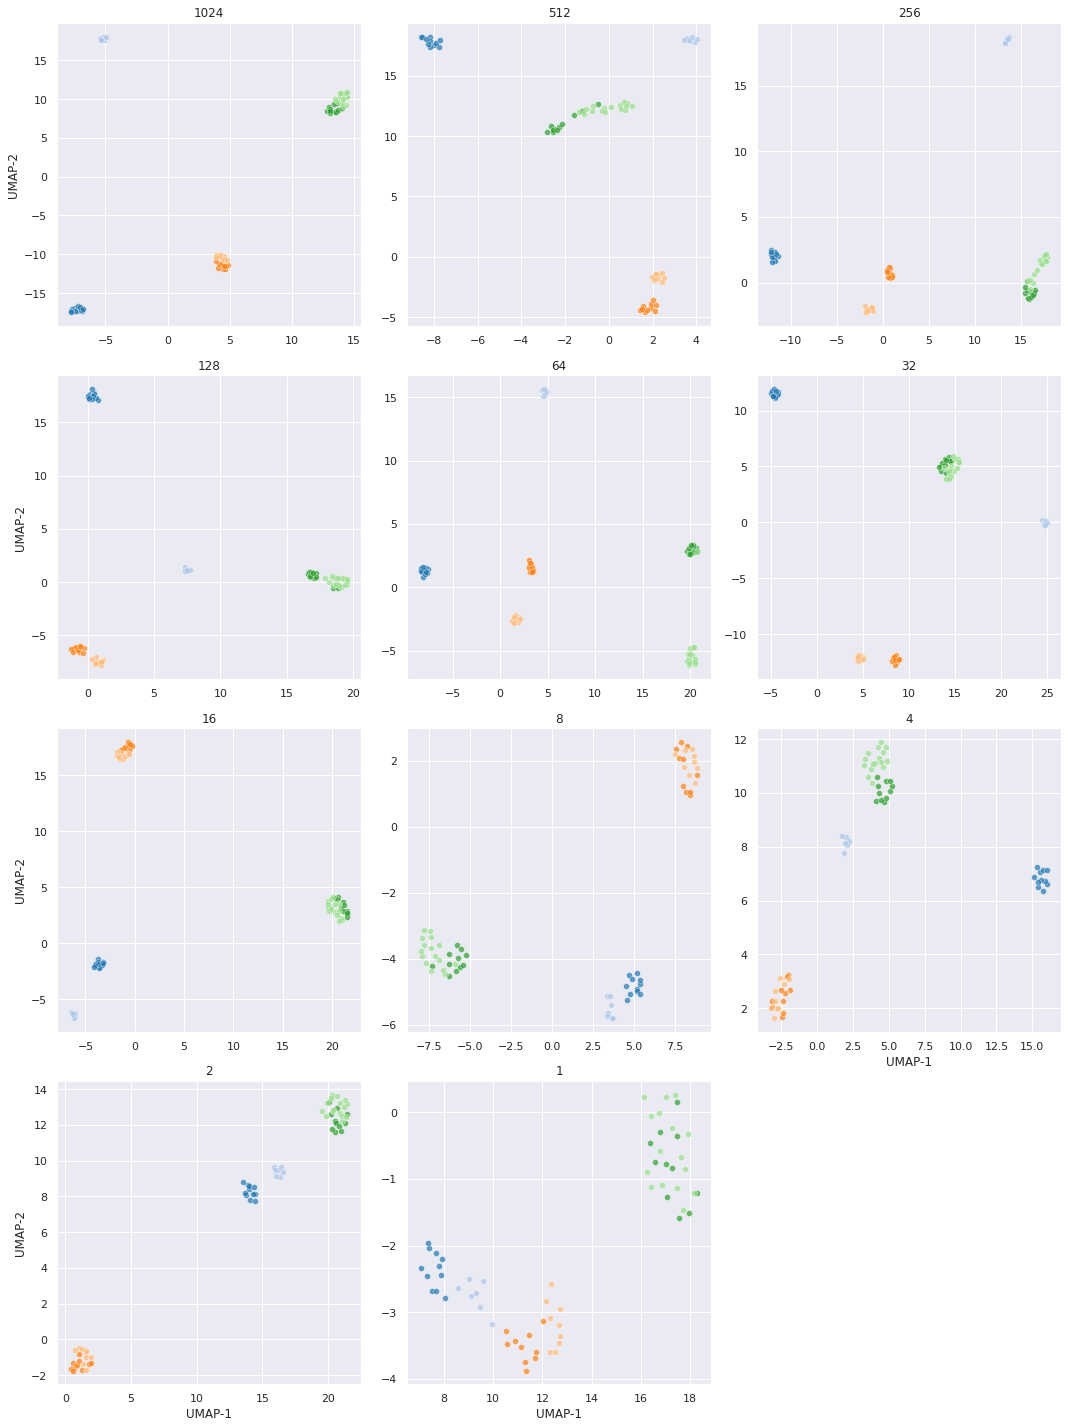

In [25]:
g = sns.FacetGrid(df_emb, col="resolution", hue="class", col_wrap=3, margin_titles=True, despine=False, height=5, sharex=False, sharey=False)
g.map(sns.scatterplot, "UMAP-1", "UMAP-2", alpha=.7)

axes = g.axes.flatten()
for j in range(J):
    axes[j].set_title(f"{2**(J-j-1)}")

## Compare to the UMAP of the true wavelet coefficients

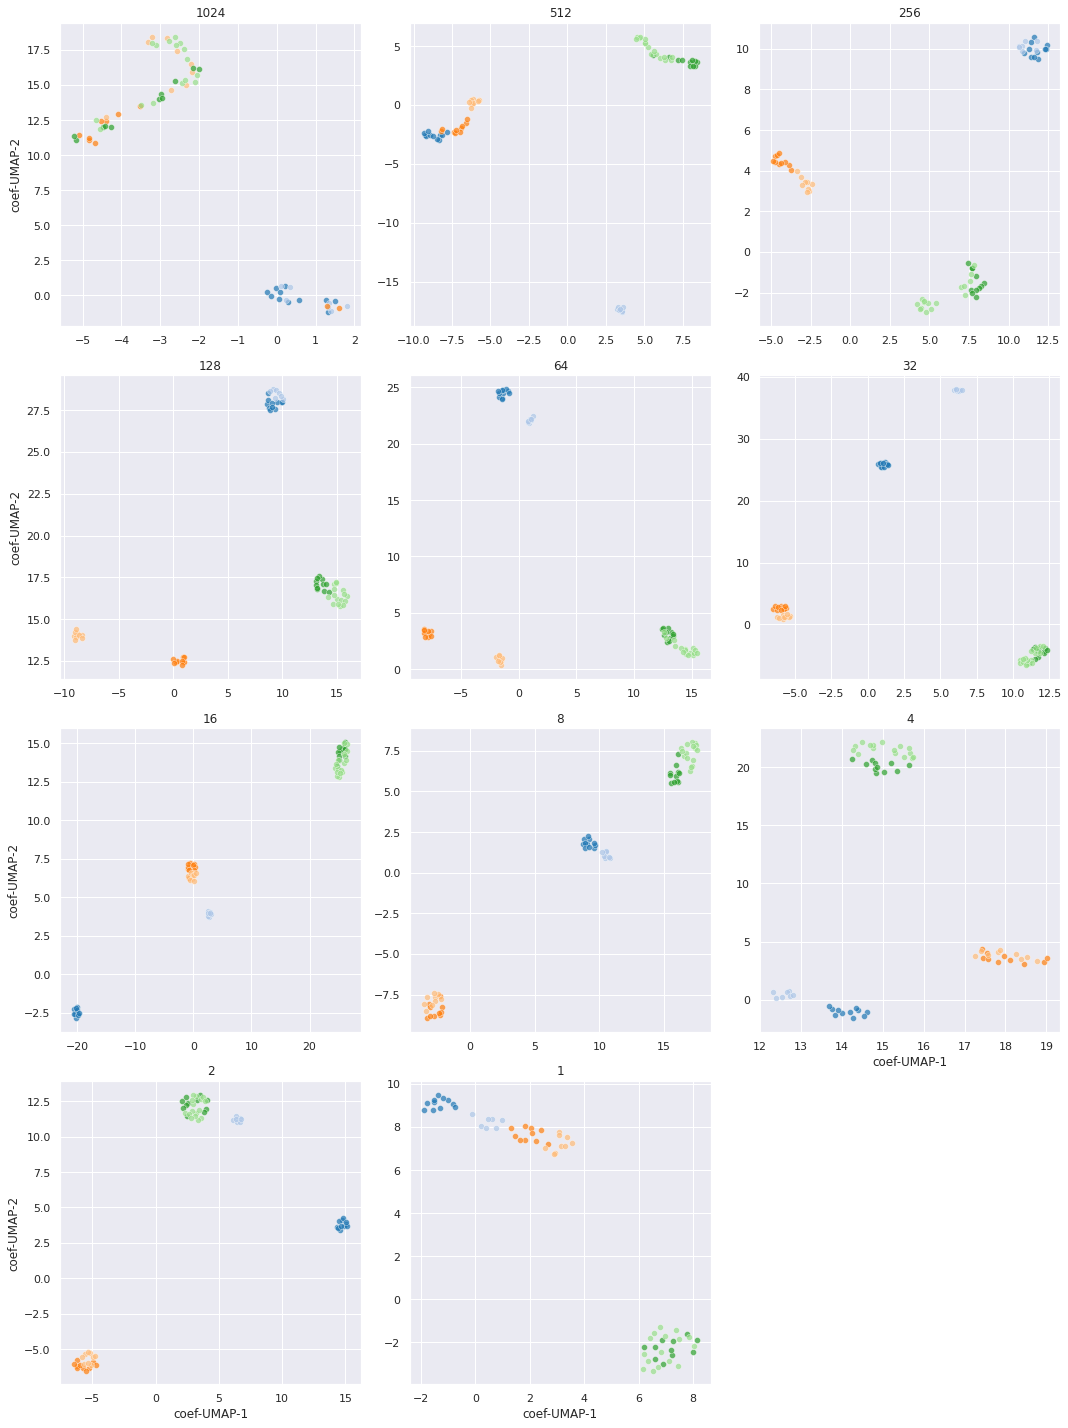

In [26]:
g = sns.FacetGrid(df_emb, col="resolution", hue="class", col_wrap=3, margin_titles=True, despine=False, height=5, sharex=False, sharey=False)
g.map(sns.scatterplot, "coef-UMAP-1", "coef-UMAP-2", alpha=.7)

axes = g.axes.flatten()
for j in range(J):
    axes[j].set_title(f"{2**(J-j-1)}")

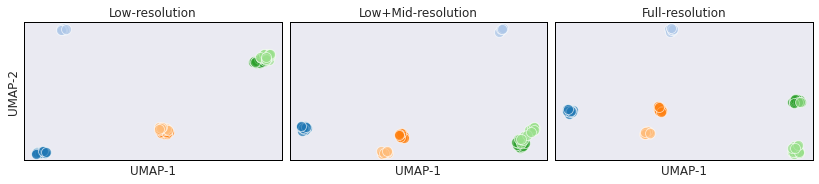

In [27]:
df_fig1 = df_emb[df_emb["resolution"].isin([f"{i}-resolution" for i in [0,2,4]])]
df_fig1_zoom = df_emb[df_emb["class"].isin([5, 6])]

g = sns.FacetGrid(df_fig1, col="resolution", hue="class", margin_titles=True, despine=False, height=3, aspect=4/3, sharex=False, sharey=False)
g.map(sns.scatterplot, "UMAP-1", "UMAP-2", alpha=0.7, s=100)
g.figure.subplots_adjust(wspace=0.03, hspace=0.1)
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)

axes = g.axes.flatten()
for res_idx, res in enumerate(["Low-resolution", "Low+Mid-resolution", "Full-resolution"]):
    axes[res_idx].set_title(res)

g.set(xticks=[])
g.set(yticks=[])
g.set_xlabels(label="UMAP-1", clear_inner=True, )
g.set_ylabels(label="UMAP-2", clear_inner=True, )


for ax in g.axes.flatten(): # Loop directly on the flattened axes 
    for _, spine in ax.spines.items():
        spine.set_visible(True) # You have to first turn them on
        spine.set_color('black')
        spine.set_linewidth(1)
        
    
        
plt.savefig("toy1_scale_embeddings.pdf", dpi=500, format='pdf', transparent=True)